In [1]:
__author__ = "me"
__date__ = "2016_02_01"


import matplotlib
matplotlib.use('Agg')


%pylab inline


import matplotlib.pyplot as plt

import sqlite3
import datetime
import dateutil.parser

import pandas as pd

import geopandas as gp
from shapely.geometry import Point
from geopandas.tools import sjoin
import pysal

from palettable.cubehelix import red_16_r

import os
import ast
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
import misc

In [3]:
def averageWeek(df, ax, tcol='ts', ccol='id', label=None, treshold=0, normalize=True, verbose=True, **kwargs):
    '''calculate average week on ts'''
    
    s = df[[tcol, ccol]].rename(columns={tcol:'ts',ccol:'id'}) # rename to convention
    
    s = df[['id', 'ts']].set_index('ts').resample('15Min', how='count').reset_index()
    s['id'] = s['id'].astype(float)


    s['ts'] = s.ts.apply(lambda x: datetime.datetime(year=2015,month=1, 
                                                              day=(x.weekday()+1), 
                                                              hour=x.hour, 
                                                              minute = x.minute))
    
    s = s.groupby(['ts']).agg('mean')
    
    
    if not label:
        label = ccol
    
    if s.id.sum() >= treshold:
        if normalize:
            sNorm = 1.0*s/s.sum()
        else:
            sNorm = s
        
        sNorm.rename(columns={'id':label}, inplace=1)
        
        sNorm.plot(ax=ax, legend=False, **kwargs);

        
        
    else:
        if verbose:
            print name, 'didnt pass treshhold:', s['id'].sum()
        else:
            pass
    
    return s.rename(columns={'id':label})

In [4]:
def bulkWeeks(df, attr, title='', av=False, th=0, legend=False, **kwargs):
    fig, ax = plt.subplots(figsize=(18,6))

    weeks = []


    for name, g in df.groupby(attr):
        
        zs = averageWeek(g, ax=ax, label=name, alpha=.5, treshold=th, **kwargs)
        weeks.append(zs)
    
    data = pd.concat(weeks, axis=1)
    if av:
        d = data.mean(axis=1)
        (1.0*d/d.sum()).plot(ax=ax, lw=1.4, color='k', label='Average')


    ax.set_title('%s, treshold=%d' % (title,th), fontsize=15);
    
    if legend:
        ax.legend()

    labels = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    dates = [datetime.datetime(year=2015, month=1, day=i, hour=0, minute=0) for i in range(1,8)]

    ax.set_xticklabels([],minor=False) # the default
    ax.set_xticklabels(labels,minor=True)

    for d in dates:
        ax.axvline(x=d, ymin=0, ymax=1)

    return data
    
    

## READING AND PROCESSING

In [6]:
folder = os.getenv('PWD') + '/data/MASTERDB/'
path = misc.mostRecentFile(folder)
x = '/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/data/MASTERDB/MERGED_on_2016-02-22 17:58:20.db'

In [7]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///%s' % x)

with engine.connect() as conn, conn.begin():
    columns = ('id','timestamp','lon', 'lat', 'tweet', 'user_id', 'rtwts', 'fvrts', 'application', 'source')
    
    data = pd.read_sql_table('tweets', conn, columns=columns)
    data['ts'] = pd.to_datetime(data.timestamp, unit='s') - datetime.timedelta(hours=5) ## UTS - 5h NYC
    
    gdf  = misc.toGeoDataFrame(data, lat='lat',lon='lon')  


In [12]:
# filtering non-NYC
gdf = gdf[(pd.notnull(gdf.lon))&(pd.notnull(gdf.lat))]

## ZIPS

In [20]:
zipPath = os.getenv('PWD') + '/data/misk/nyc-zip-code-tabulation-areas-polygons.geojson'
zips = gp.read_file(zipPath)[['geometry', 'postalCode']]
print zips.crs

{'init': u'epsg:4326'}


In [13]:
gdf2 = sjoin(gdf, zips, how="left", op='within')

In [14]:
datum = gdf2[pd.notnull(gdf2.postalCode)]
print datum.shape

(5671909, 14)


In [15]:
datum.postalCode.value_counts().head(15)

10001    203292
10036    202901
10019    193422
10013    163276
10003    161669
10011    152304
10007    141925
11211    128002
10018    110435
10012    106226
11201    103388
10014     98913
10002     91173
10017     89420
10022     88744
Name: postalCode, dtype: int64

In [24]:
! pwd

/Users/casy/Dropbox/CUSP/GRA/QQ_GRA/CUSP_QC_twitter_scripts/code/EDA


In [5]:
import pickle
datum.to_pickle('zipJoined.pkl')

NameError: name 'datum' is not defined

In [6]:
datum = pd.read_pickle('zipJoined.pkl')

In [7]:
datum.columns

Index([         u'id',   u'timestamp',         u'lon',         u'lat',
             u'tweet',     u'user_id',       u'rtwts',       u'fvrts',
       u'application',      u'source',          u'ts',    u'geometry',
       u'index_right',  u'postalCode'],
      dtype='object')

## Timeline

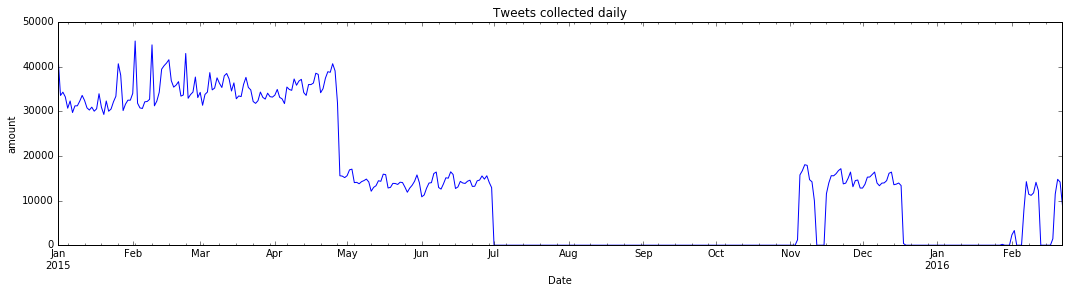

In [25]:
def timeCoverage(df, timeCol='ts', countCol='id', rs='D'):
    dft = df[[timeCol, countCol]].set_index(timeCol).resample(rs, how='count')
    dft.plot(figsize=(18,4), legend=0, title='Tweets collected daily');
    plt.xlabel('Date');
    plt.ylabel('amount');

timeCoverage(datum)

## APPS

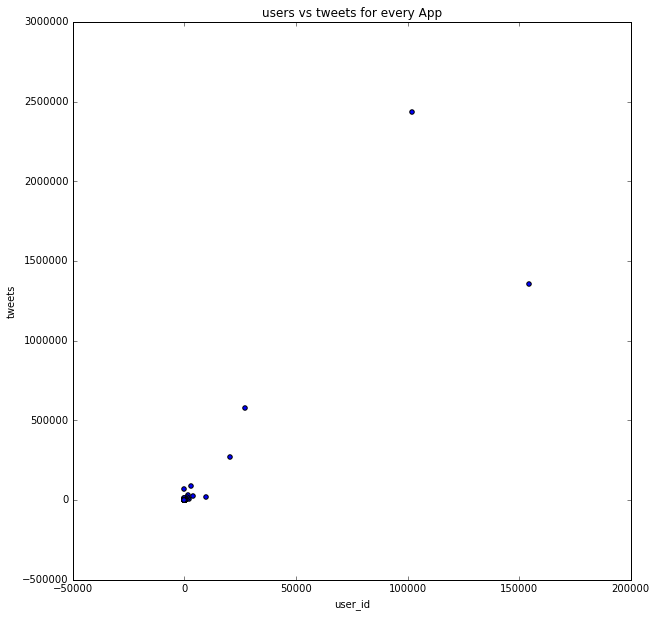

In [34]:
apps = datum[['application','user_id', 'id']].groupby('application').agg({'user_id':pd.Series.nunique, 'id':'count'}).sort_values(by='user_id', ascending=0)
apps.rename(columns={'id':'tweets'}, inplace=1)
apps.plot(kind='scatter', x='user_id', y='tweets', logy=0, logx=0, figsize=(10,10), title='users vs tweets for every App');


In [35]:
# potential Foursquare

#print len(gdf)
#print len(gdf[(gdf.tweet.str.contains("I'm at")) | (gdf.application == 'Foursquare')])

In [36]:
apps['fraction'] = 1.0*apps.tweets/apps.user_id
apps.sort_values('tweets', ascending=0).head(20)

,user_id,tweets,fraction
application,,,
Twitter for iPhone,101748,2435349,23.935104
Instagram,154486,1353029,8.758263
Twitter for Android,26925,580972,21.577419
Foursquare,20626,272112,13.192669
Twitter for iPad,2904,89511,30.823347
dlvr.it,23,68478,2977.304348
Tweetbot for iΟS,1673,29389,17.566647
Squarespace 6,3843,24761,6.443143
iOS,9464,22517,2.379227


In [37]:
apps[apps.index.str.lower().str.contains('twitter')]
# apps.index

,user_id,tweets,fraction
application,,,
Twitter for iPhone,101748,2435349,23.935104
Twitter for Android,26925,580972,21.577419
Twitter for iPad,2904,89511,30.823347
Twitter for Android Tablets,981,22240,22.670744
Twitter for Windows Phone,536,16390,30.578358
Twitter for BlackBerry,156,1079,6.916667
Twitter for BlackBerry®,98,1333,13.602041
Twitterrific,93,604,6.494624
Twitter for iPhone,90,832,9.244444


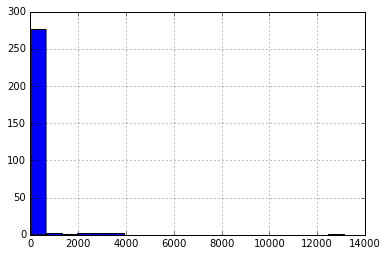

In [38]:
apps.fraction.hist(bins=20)

In [39]:
apps.sort_values('fraction', ascending=0).head(30)

,user_id,tweets,fraction
application,,,
COS App,1,13120,13120.000000
SimplyCast,2,7256,3628.000000
twitrriffic,1,3535,3535.000000
dlvr.it,23,68478,2977.304348
dine here,1,2663,2663.000000
TTN NYC traffic,1,2448,2448.000000
pbump.net,2,4711,2355.500000
kickalert,1,2153,2153.000000
eLobbyist,1,1353,1353.000000


In [16]:
superaps = datum.application.value_counts().head(20).index.tolist()

In [18]:
sa_datum = datum[datum.application.isin(superaps)]

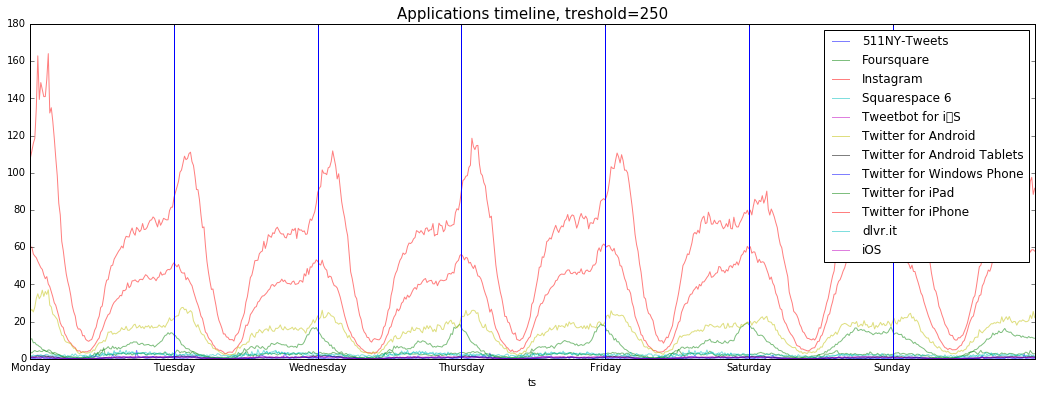

In [19]:
x = bulkWeeks(sa_datum, 'application', title='Applications timeline', 
              av=False, th=250, legend=True, verbose=False, normalize=False)

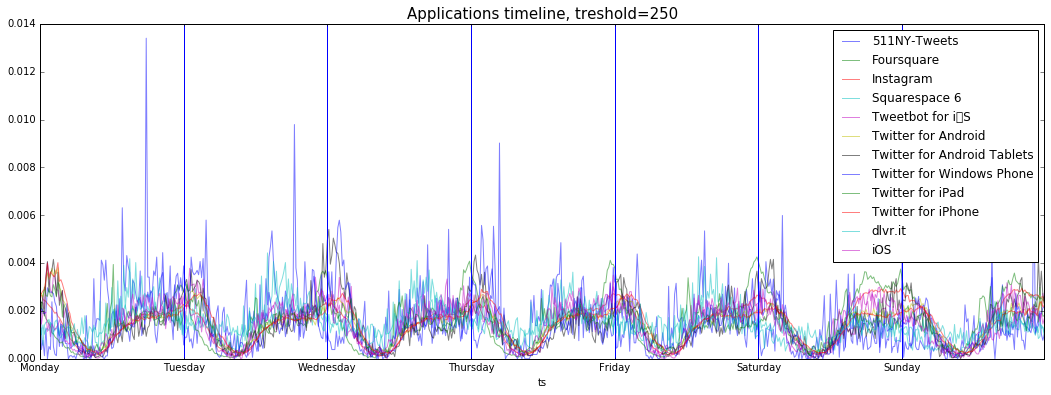

In [20]:
x = bulkWeeks(sa_datum, 'application', title='Applications timeline', 
              av=False, th=250, legend=True, verbose=False, normalize=True)

In [35]:
def cdf(gdf, ax, **kwargs):
    users = gdf.user_id.value_counts( ascending=True ).cumsum()
    
    x = pd.qcut(users, 10)
    u = users.groupby(x).agg(sum)
    u = u.astype(float)/u.max()
    u.index = range(len(u))
    u.plot(**kwargs)

ValueError: Bin edges must be unique: array([13120, 13120, 13120, 13120, 13120, 13120, 13120, 13120, 13120,
       13120, 13120])

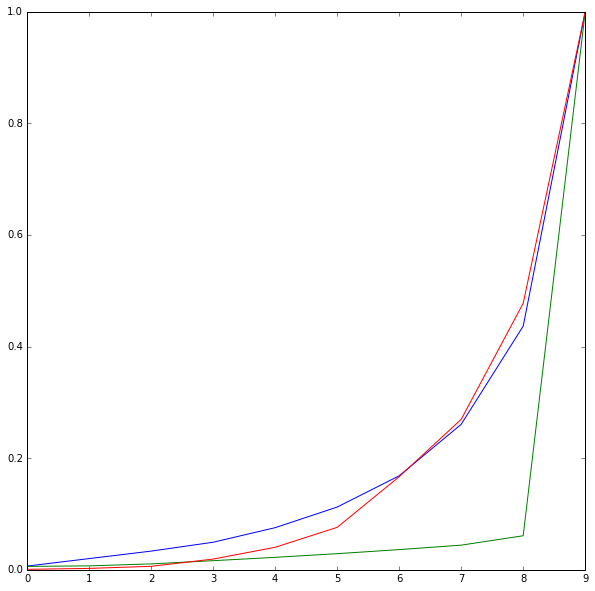

In [36]:
fig, ax = plt.subplots(figsize=(10,10))    

cdf(gdf, ax=ax, label='All')
th=500
for name, g in gdf.groupby('application'):
    if len(g) > th:
        cdf(g, ax=ax, label=name)
        
plt.legend();
plt.title('Apps user/impact ')

In [37]:
gdf[gdf.application == '511NY-Tweets'].user_id.value_counts()

52272942    8961
50706690    7623
55346033     465
55007804     220
50729679     201
55005906     181
55008355     165
55007056     159
55009342      97
55009968      81
50728535      60
55008759      54
Name: user_id, dtype: int64

In [23]:
gdf.source.value_counts()

twitter1.db                      626920
C_2016_02_12_twitter.db           33650
DO_2016_02_07_twitter.db          22016
DO_2016_02_12_twitter.db          15708
gnip                              13029
GNIP_Nov17_28                     12275
C_2016_02_9_twitterB.db           12095
C_2016_02_08.db                    3277
C_2016_02_7_Cusp_twitter.db        2701
C_2016_02_10.db                    1050
DO_2016_02__6_twitter.db            589
twitter2.db                         221
C_2016_92_7_Cusp_twitter_1.db        54
Name: source, dtype: int64

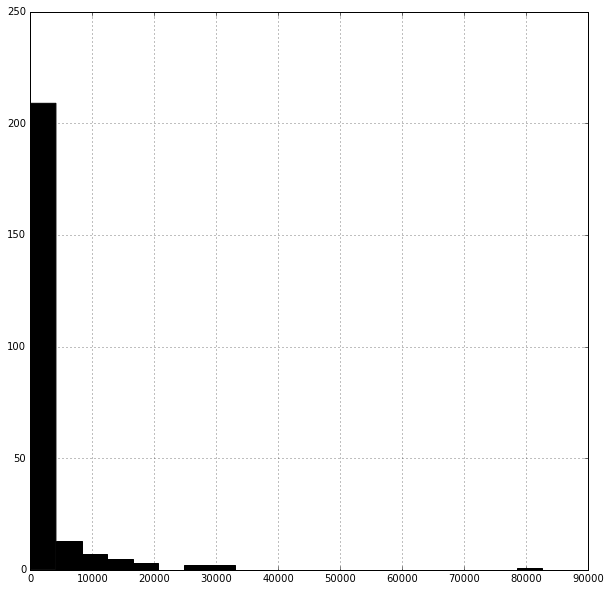

In [31]:
gdf2.postalCode.value_counts().hist(bins=20, figsize=(10,10), color='k');

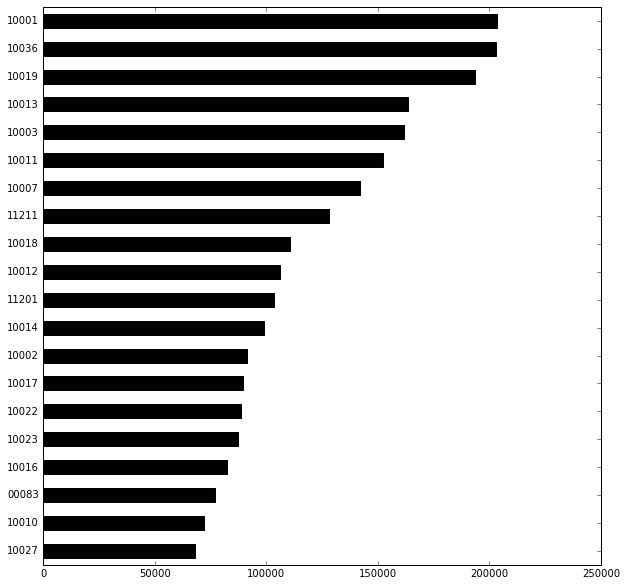

In [17]:
datum.postalCode.value_counts().sort_values(axis=0, ascending=False, inplace=0).head(20).iloc[::-1].plot(kind='barh', figsize=(10,10), color='k');
# plt.title('20 ZIPCODES with the most geolocated tweets')

## MAPPING ZIPS

In [81]:
zipheat = datum.postalCode.value_counts().reset_index().rename(columns={'index':'postalCode','postalCode':'tweetsTotal'})
zipheat.head(2)

,postalCode,tweetsTotal
0,10001,203292
1,10036,202901


In [82]:
zips2 = zips.merge(zipheat, on='postalCode', how='left')
zips2['normalized'] = zips2['tweetsTotal'] / zips2.geometry.area

In [83]:
zips2.head(2)

,geometry,postalCode,tweetsTotal,normalized
0,POLYGON ((-73.86942457284175 40.74915687096787...,11372,18213,91076185.369467
1,POLYGON ((-73.71068374074007 40.75004039450917...,11004,45,200786.627832


In [84]:
zips2.tweetsTotal.sum()

5882295

/Users/casy/anaconda/lib/python2.7/site-packages/geopandas-0.1.0.dev1451292-py2.7.egg/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)


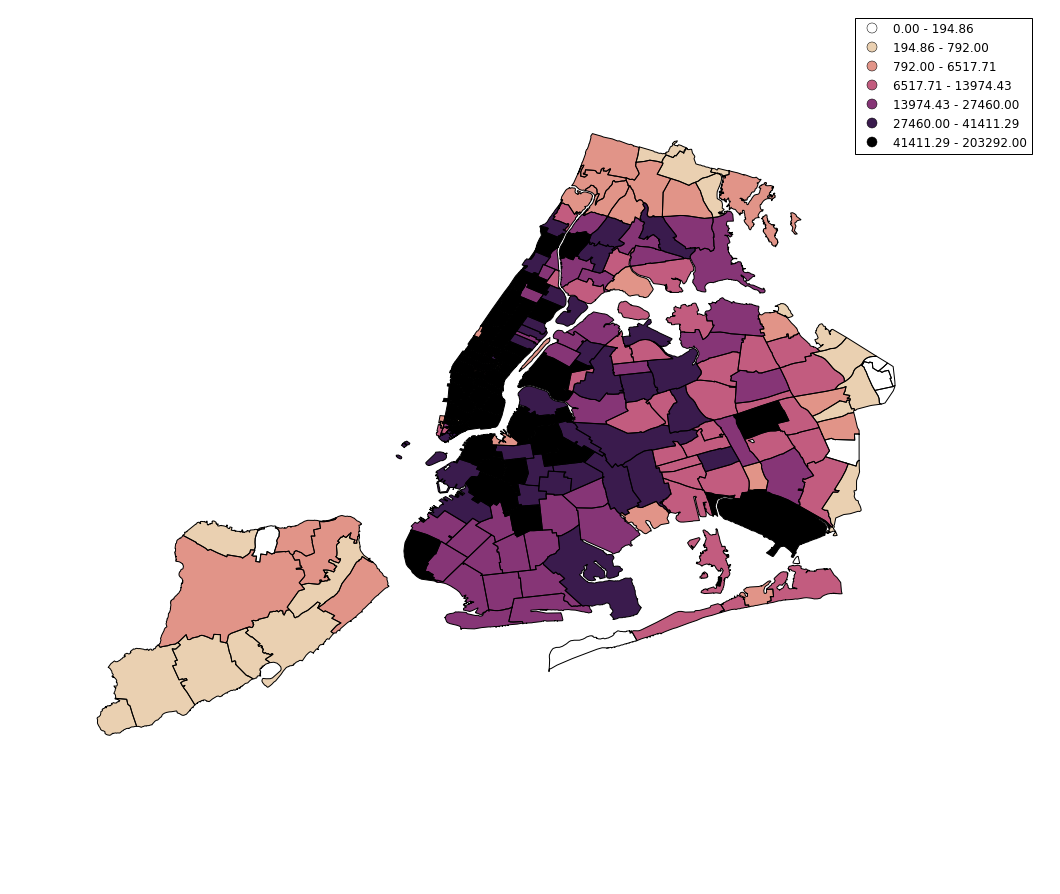

In [22]:
zips2[pd.notnull(zips2.tweetsTotal)].plot(column='tweetsTotal', scheme='QUANTILES', k=7, 
           colormap=red_16_r.mpl_colormap, figsize=(18,18),
           alpha=1, legend=True)

# plt.title('Total Number of tweets per zipcode', fontsize=20)
plt.axis('off');

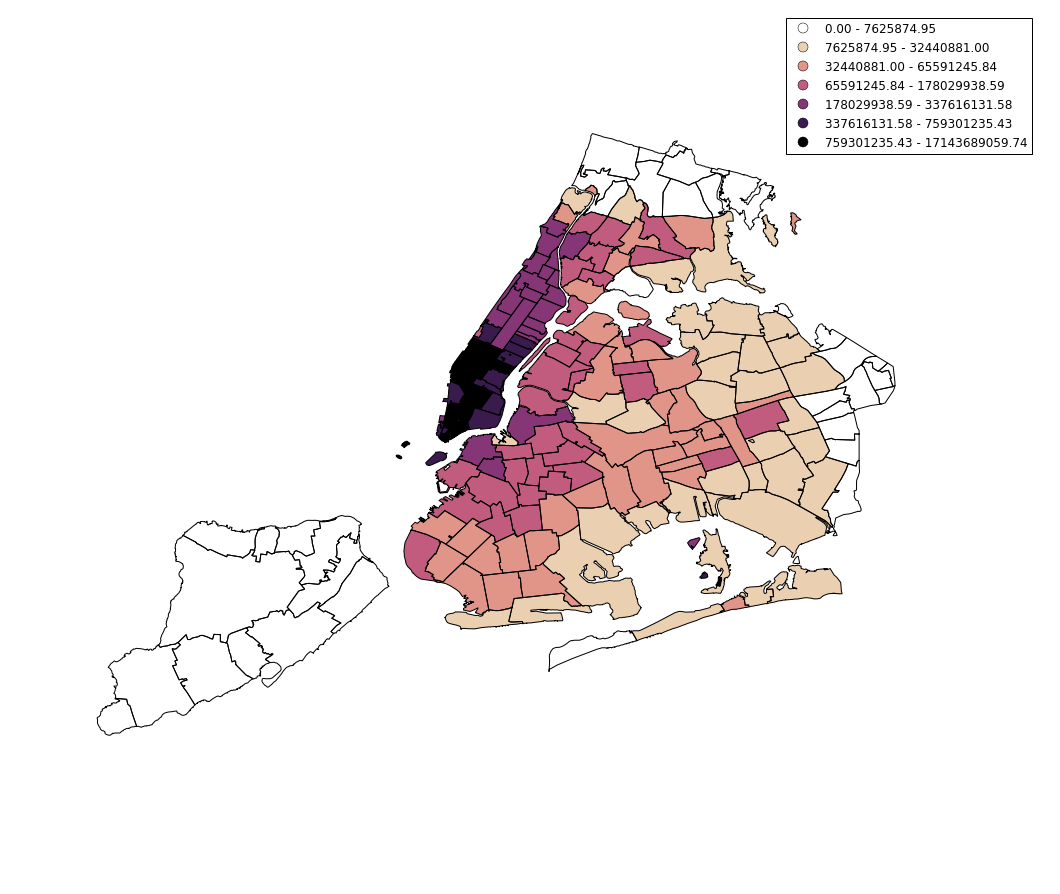

In [23]:
zips2[pd.notnull(zips2.tweetsTotal)].plot(column='normalized', scheme='QUANTILES', k=7, 
           colormap=red_16_r.mpl_colormap, figsize=(18,18),
           alpha=1, legend=True)

# plt.title('Number of tweets per zipcode, normalized by area', fontsize=20)
plt.axis('off');

## AVERAGE WEEK

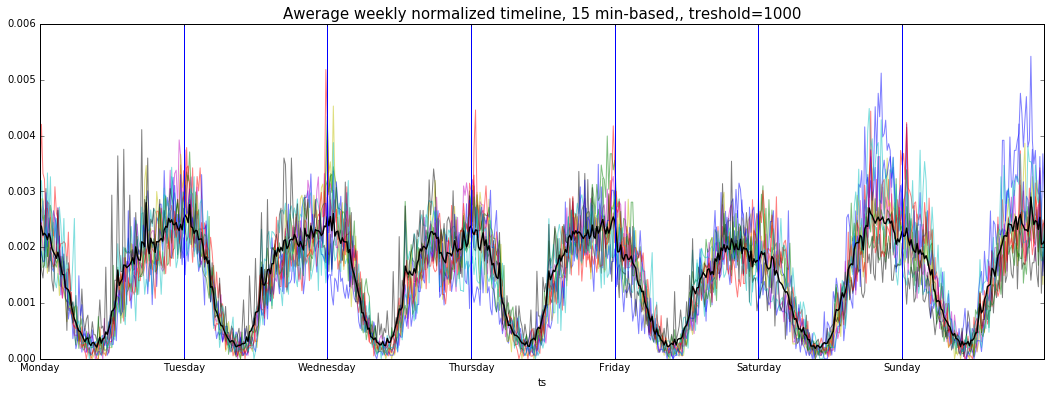

In [39]:
x = bulkWeeks(gdf2, 'postalCode', title='Awerage weekly normalized timeline, 15 min-based,',
          av=True, th=1000, legend=False, verbose=False)

## GEO for ROBOTS?

In [40]:
# looking at geocoding for specific app - it is not the same.
gdf[['lat','lon','id','user_id']].groupby(['lat','lon']).agg({'id':'count'}).sort_values('id', ascending=False).head(10)

,,id
lat,lon,
40.714200,-74.006400,76065
40.716698,-74.000016,31564
40.720756,-74.000761,24489
40.714353,-74.005973,20765
40.758895,-73.985131,16145
40.768924,-73.975307,13019
40.654871,-74.006435,12395
40.710989,-74.004044,10295
40.720756,-74.000761,10267


## One user in one place

In [46]:
uid_lat_count = gdf[['lat','lon','id','user_id']].groupby('user_id').agg({'lat':lambda x: len(set(x))}).sort_values('lat', ascending=0)
uid_lat_count.head(10)

,lat
user_id,
3035345375,15193
35033769,14699
110937131,11217
242992653,10361
1633493004,8753
180202528,8299
216177858,6778
338661490,6749
1443033678,6741


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x15c6e0790>]], dtype=object)

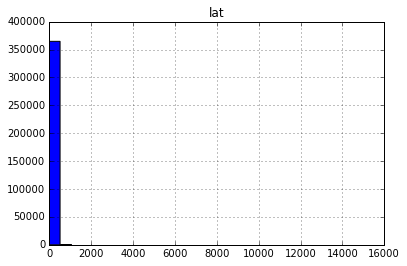

In [49]:
uid_lat_count.hist(bins=30)

In [51]:
gdf[gdf.user_id==3035345375].head(20).tweet

1740823    Can someone please shut @EBischoff the hell up...
1740873    @EBischoff Watching an old Nitro from 1997 and...
1741048    Let me just say as a former WCW fanboy @Genuin...
1756052                      @AliciaFoxy Truly Foxy as usual
1756082                @RealSummerWWE How are u still single
1756212    @CarmellaWWE @BigCassWWE @WWEAaLLday21 If I di...
1965981    @KaneWWE is @TripleH's Director of Operations ...
1966075    Combined @KaneWWE and @TripleH has held 23 Wor...
1966117    @TripleH is good friends with the rock band @m...
1966154    @HeymanHustle took the helm of commentary alon...
1966201    Believe it or Not @steveaustinBSR and @TripleH...
1966245    Referee Tim White had his career shortened by ...
1966288    @StephMcMahon took the name Stephanie McMahon ...
1966324    As part of his 2001 face turn The Undertaker r...
1966379    @TripleH @StephMcMahon @steveaustinBSR @MATTHA...
1966412    @TripleH's 1st Pay Per View match was a Hog Pe...
1966435    The Intercont

In [53]:
gdf[gdf.user_id==35033769].head(20).tweet

1887     @DunkinDonuts #DDNewYearsSweeps All teachers a...
2086     @theislegardener @MasterCard really.u not tell...
2112     @MasterCard #NYE2015 surrounded by your friend...
2188     @KurioTabletUSA #NYE2015 #kurio bring my siste...
2252     @drpepper to be a see my son again... #DrPeppe...
2339                       @PlanetShoes pink ones!! please
2381     @MLBPAClubhouse  #NewYearsResolution #HappyNew...
21943    @StubHub  #NYE #NYE2015 #tixwish! please!!! se...
22096    @Andy @surface #HolidayProSweeps  cranberry vo...
22457    was weathering the cold making history in Broo...
23423                             @JoAnnBelaus where u go?
23519    @terresaling @bitecharge Your inner nationalit...
23539     @ActionJackson66 oh nice !how did u get the tix?
23565    @JoAnnBelaus send me pics! we had fun at Coney...
23588    @JoAnnBelaus lol.my hair was under a hat! and ...
23687    @JoAnnBelaus it took my dad 40min to drive  ba...
24178    @ActionJackson66 i figured you worked there.th.

## Misterious point in lower Manhattan

In [41]:
gdf[(gdf.lat==-74.006400) & (gdf.lon == 40.714200)].tail(10)[['tweet','user_id']]

,tweet,user_id
743517,Backstage: Mirror Mirror. Fall 16. Photo by so...,29137655
743524,Still cant believe that Im one of the 8 finali...,242147910
743532,Attempting @davidlebovitz recipe for clam chow...,12967342
743540,Cushnie Et Ochs show 👏🏼 Full Brows + lots of...,29157995
743551,Best Day Ever with @50cent #jamiemakeup #power...,17607982
743558,"No one ever makes me feel like you do, when yo...",4735541369
743564,Dedication with a side of crazy || Respect || ...,22926745
743566,Will be available soon! 😜😎👍 #LIFESTYLE #LIF...,1452550058
743578,Jason Wu Runway Show at New York Fashion Week ...,3003860652
743580,"The Plaza Hotel 🗽 #homealone @ New York, New ...",296470026


In [42]:
gdf[gdf.application == '511NY-Tweets'].head(10)[['lon','lat','tweet']]

,lon,lat,tweet
120587,40.750127,-73.989876,Special event on #MadisonSquareGarden at the A...
123793,40.800130,-73.927599,Construction on #RFKTriboroughBridge WB at Man...
124510,40.850318,-73.945276,Construction on #GeorgeWashingtonBridge WB fro...
124641,40.728114,-74.024680,Construction on #HollandTunnel EB from New Jer...
124732,40.701698,-74.010597,Construction on #FranklinDRooseveltDrive SB fr...
124913,40.845339,-73.930614,Construction on #GeorgeWashingtonBridge WB fro...
124914,40.845339,-73.930614,Construction on #GeorgeWashingtonBridge WB fro...
124915,40.752071,-73.977653,Incident on #NewHavenLine BOTHDIR from Grand C...
124916,40.752071,-73.977653,Incident on #NewHavenLine BOTHDIR from Grand C...
124917,40.774299,-73.922401,Construction on #I278 WB from 23rd Street to S...


## ROBOTS

In [43]:
gdf2[gdf2.application=='511NY-Tweets'].tweet.iloc[3]

u'Construction on #HollandTunnel EB from New Jersey Side - South Tube to New York Side - South Tube https://t.co/zIbmXjfekb'

In [44]:
def cleanRobots(df):
    '''first attempt to remove robots'''
    apps = ['511NY-Tweets']
    users = []
    
    # add app_robot_users --- for our scraper data, that lacks app_signature
    users.extend(df[df.application.isin(apps)].user_id.unique().tolist())
    print users
    return df[(~ df.application.isin(apps)) & (~ df.user_id.isin(users))]
    

In [45]:
def removeSingles(df):
    users = df.user_id.value_counts()
    singles = users[users==1].index.tolist()
    
    return df[ ~ df.user_id.isin(singles)]


In [46]:
# clean = removeSingles(cleanRobots(gdf2))
clean = cleanRobots(gdf2)

[52272942, 50706690, 55008759, 55007056, 55008355, 55005906, 55007804, 55346033, 55009968, 50728535, 50729679]


In [47]:
# len(clean)

727120

In [48]:
users = clean
top = users.head(30).index.tolist()

In [49]:

cleanData = clean

In [50]:
len(cleanData)

727120

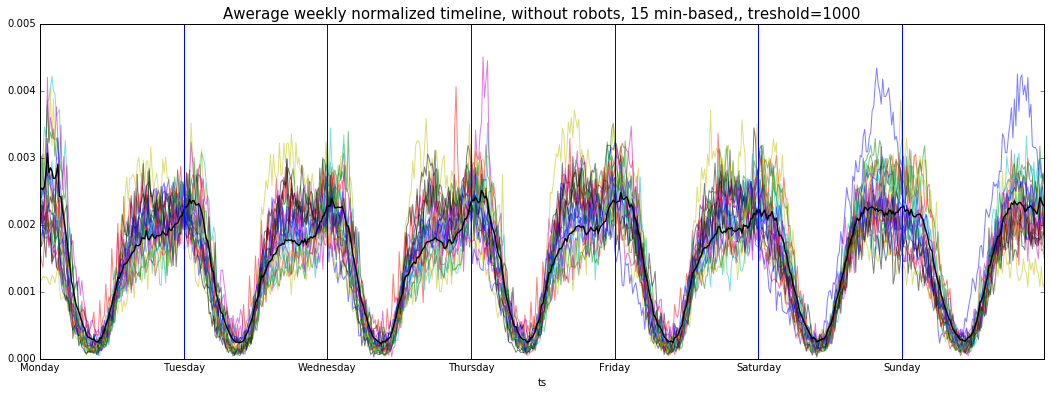

In [8]:
x = bulkWeeks(datum, 'postalCode', title='Awerage weekly normalized timeline, without robots, 15 min-based,',
          av=True, th=1000, legend=False, verbose=False)

In [11]:
LM = [str(x) for x in [10004, 10005, 10006, 10007, 10038, 10280]]

In [12]:
LMdata = datum[datum.postalCode.isin(LM)]

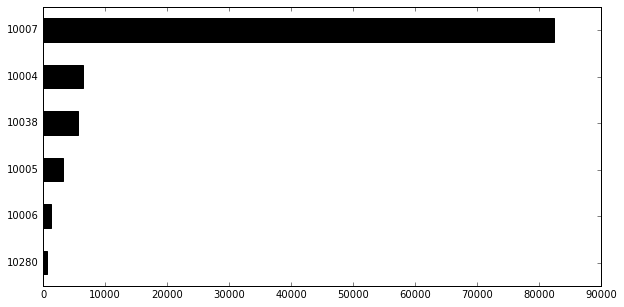

In [54]:
LMdata.postalCode.value_counts().iloc[::-1].plot(kind='barh', color='k', figsize=(10,5))

In [56]:
len(gdf)

743585

In [24]:
len(LMdata)

293731

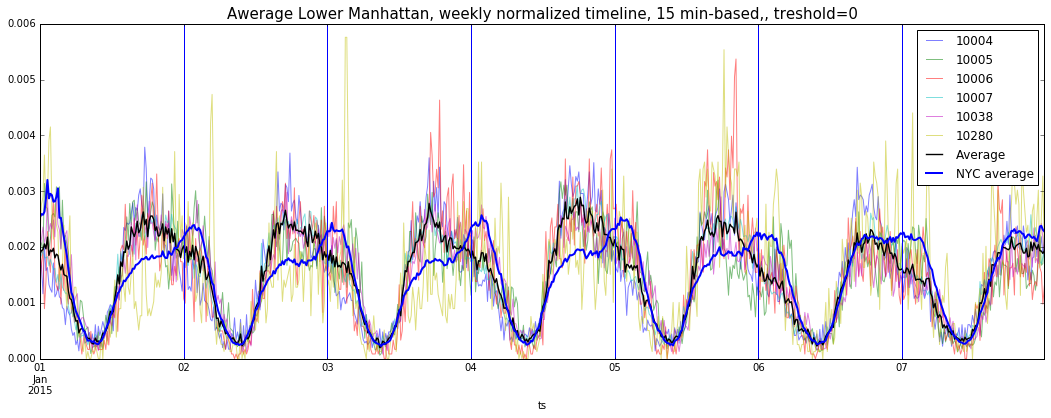

In [23]:
lmweek = bulkWeeks(LMdata, 'postalCode', title='Awerage Lower Manhattan, weekly normalized timeline, 15 min-based,',
          av=True, th=0, legend=True, verbose=False)

aW = x.mean(1)
aW = aW/aW.sum()
aW.plot(lw=2, c='blue', label='NYC average')
plt.ylim(0,0.006)
plt.legend()


## CLUSTERING

In [34]:
from scipy.cluster.vq import kmeans2
import Pycluster

def clusterAndPlot(df,k, height=10):
    '''calculate and plot kmean clustering'''
    fig, axes = plt.subplots(k+1, figsize=(18,height), sharex='all', sharey='all')
    
#     centroids, label = kmeans2(df, k, iter=100, thresh=1e-05)
    labels, error, nfound = Pycluster.kcluster(df, k)
    df['label'] = labels
    
    
    #one by one
    for l, g in df.groupby('label'):
        g.T.plot(ax=axes[l], legend=0, c='k',alpha=.2)
        axes[l].set_title('cluster %d, %d zipcodes'% (l, len(g)))
        
        pd.Series(g.mean(0)).plot(ax=axes[-1], label='cluster %d'% (l ))
        

#     plt.legend()
    return df

In [35]:
def normaliseTimeseries(df, transpose=True):
    '''transpose and normilize timeseries by themself
       removing the median and dividing by sdt'''
    
    if transpose:
        df = df.T
    
    return (df - df.mean(0))/df.std(0)
    

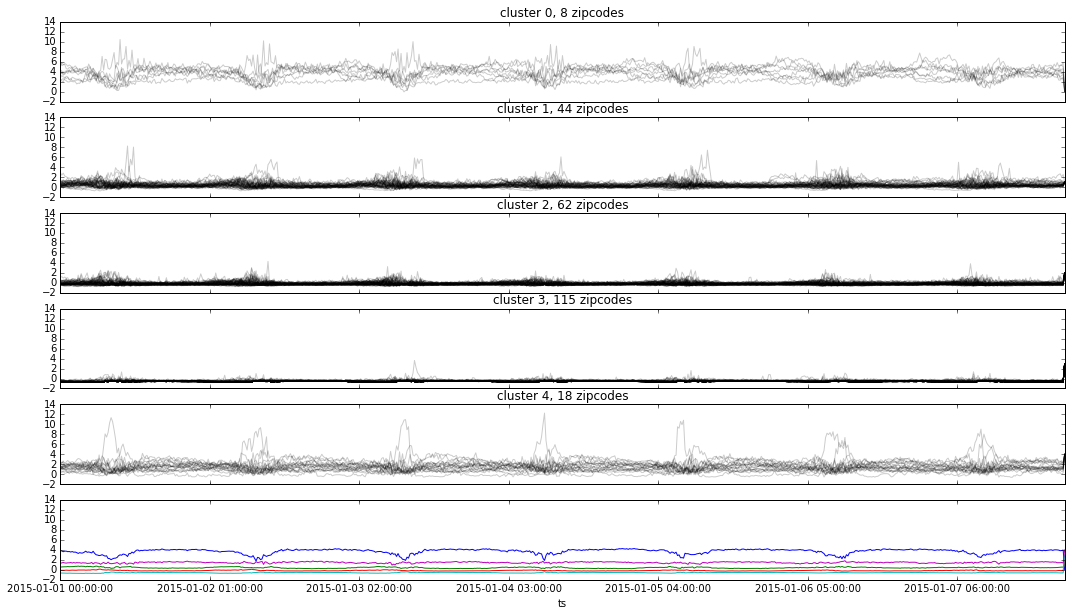

In [36]:
normTS = normaliseTimeseries(x) 

dfLabels = clusterAndPlot(normTS, 5, height=10)

In [25]:
labels = dfLabels.reset_index()[['index','label']].rename(columns={'index':'postalCode'})
labelZip = zips.merge(labels, how='left', on='postalCode')

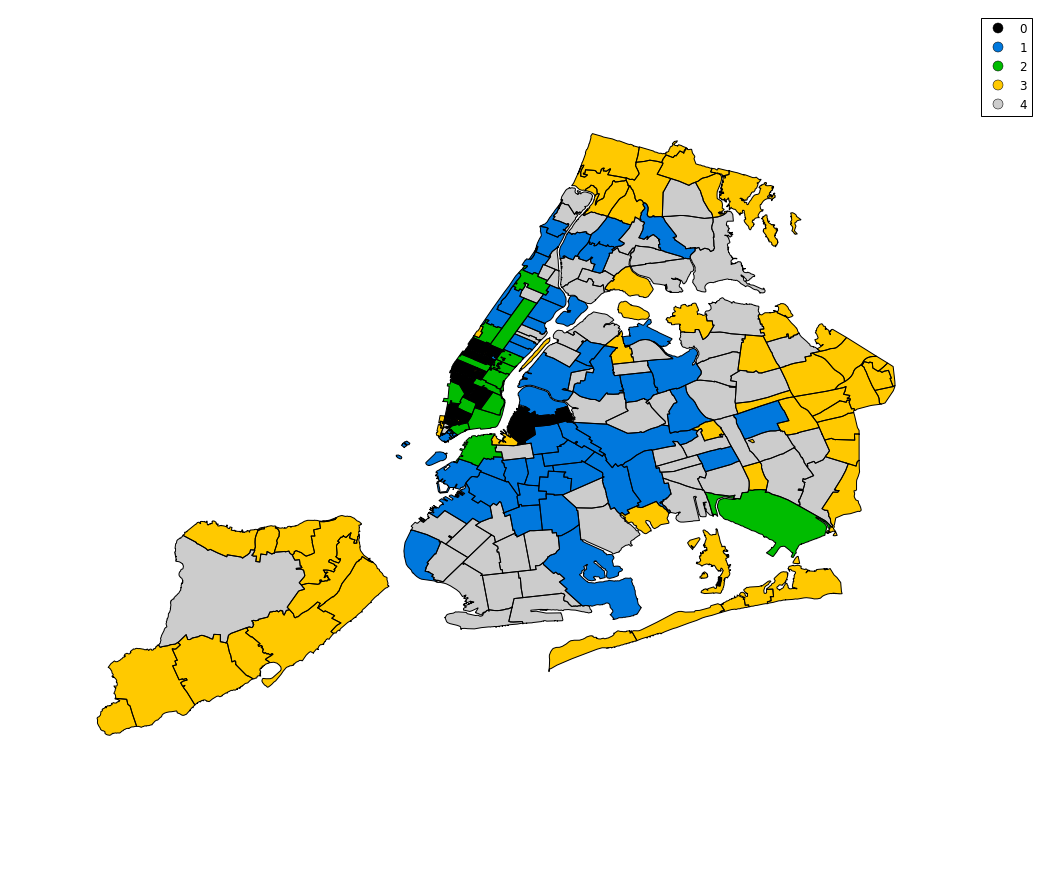

In [28]:
labelZip.plot(column='label', categorical=1,
           colormap='spectral', figsize=(18,18),
           alpha=1, legend=True)

# plt.title('Total Number of tweets per zipcode', fontsize=20)
plt.axis('off');